### Description
Ce fichier a pour objectif d’élaborer une architecture de réseau de neurones convolutif (CNN) et de l'entraîner sur un ensemble d'entraînement composé de 24 000 images, réparties équitablement entre six espèces aquatiques.

Les données d’entraînement sont divisées en deux sous-ensembles : jeu d'entraînement et jeu de validation, afin d’évaluer la performance du modèle en cours d’apprentissage et d’optimiser son architecture.

Le but final est d’atteindre une exactitude (accuracy) minimale de 82% sur l’ensemble de test.

Ce fichier comprend notamment :

* La conception d'une architecture CNN personnalisée ;

* Le prétraitement des données (avec éventuellement la data augmentation) ;

* Le choix et la configuration des hyperparamètres (optimiseur, batch size, epochs, early stopping, etc.) ;

* L'entraînement du modèle ;

* La visualisation des performances via les courbes de perte et d’exactitude ;

* L’enregistrement du modèle entraîné pour l’évaluation future.

### Téléchargement des données

In [3]:
!gdown "https://drive.google.com/uc?id=1t3-PN7SpB_WB1FiIlq8n81vRrR9_PKOO"

Downloading...
From (original): https://drive.google.com/uc?id=1t3-PN7SpB_WB1FiIlq8n81vRrR9_PKOO
From (redirected): https://drive.google.com/uc?id=1t3-PN7SpB_WB1FiIlq8n81vRrR9_PKOO&confirm=t&uuid=faba69ab-6b67-472f-bc2d-684c6a6d7bf6
To: /content/donnees.zip
100% 234M/234M [00:01<00:00, 129MB/s]


In [4]:
!unzip donnees.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: donnees/entrainement/morse/0004.jpg  
  inflating: __MACOSX/donnees/entrainement/morse/._0004.jpg  
  inflating: donnees/entrainement/morse/3535.jpg  
  inflating: __MACOSX/donnees/entrainement/morse/._3535.jpg  
  inflating: donnees/entrainement/morse/1322.jpg  
  inflating: __MACOSX/donnees/entrainement/morse/._1322.jpg  
  inflating: donnees/entrainement/morse/0982.jpg  
  inflating: __MACOSX/donnees/entrainement/morse/._0982.jpg  
  inflating: donnees/entrainement/morse/1444.jpg  
  inflating: __MACOSX/donnees/entrainement/morse/._1444.jpg  
  inflating: donnees/entrainement/morse/3253.jpg  
  inflating: __MACOSX/donnees/entrainement/morse/._3253.jpg  
  inflating: donnees/entrainement/morse/2159.jpg  
  inflating: __MACOSX/donnees/entrainement/morse/._2159.jpg  
  inflating: donnees/entrainement/morse/3247.jpg  
  inflating: __MACOSX/donnees/entrainement/morse/._3247.jpg  
  inflating: donne

### Chargement des librairies

In [12]:
from tensorflow import keras

# La libraire responsable du chargement des données dans la mémoire

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Le Type de notre modéle (séquentiel)

from keras.models import Model
from keras.models import Sequential

# Le type d'optimisateur utilisé dans notre modèle (RMSprop, adam, sgd, adaboost ...)
# L'optimisateur ajuste les poids de notre modèle par descente du gradient
# Chaque optimisateur a ses propres paramètres
# Note: Il faut tester plusieurs et ajuster les paramètres afin d'avoir les meilleurs résultats

from keras.optimizers import Adam

# Les types des couches utlilisées dans notre modèle
from keras.layers import Conv2D, MaxPooling2D, Input, BatchNormalization, UpSampling2D, Activation, Dropout, Flatten, Dense, ELU

# Des outils pour suivre et gérer l'entrainement de notre modèle
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping

# Configuration du GPU
import tensorflow as tf
from keras import backend as K

# Sauvegarde du modèle
from keras.models import load_model

# Affichage des graphes
import matplotlib.pyplot as plt

import time  # Importer le module time

from tensorflow.keras.regularizers import l2

import numpy as np
import random

from tensorflow.keras.utils import plot_model
import visualkeras


# Fixer le seed pour la reproductibilité
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)

### Définition des variables et configuration des hyperparamètres

In [6]:
# Le dossier principal qui contient les données
mainDataPath = "donnees/"

# Le dossier contenant les images d'entrainement
trainPath = mainDataPath + "entrainement"

# Le dossier contenant les images de validation
validationPath = mainDataPath + "validation"

# Le dossier contenant les images de test
testPath = mainDataPath + "test"

# Le nom du fichier du modèle à sauvegarder
modelsPath = "Model.keras"


# Le nombre d'images d'entrainement et de validation
# Il faut en premier lieu identifier les paramètres du CNN qui permettent d’arriver à des bons résultats. À cette fin, la démarche générale consiste à utiliser une partie des données d’entrainement et valider les résultats avec les données de validation. Les paramètres du réseaux (nombre de couches de convolutions, de pooling, nombre de filtres, etc) devrait etre ajustés en conséquence.  Ce processus devrait se répéter jusqu’au l’obtention d’une configuration (architecture) satisfaisante.
# Si on utilise l’ensemble de données d’entrainement en entier, le processus va être long car on devrait ajuster les paramètres et reprendre le processus sur tout l’ensemble des données d’entrainement.


training_batch_size = 19200  # total 8000 (4000 classe: 2 et 4000 classe: 7)
validation_batch_size = 4800  # total 2000 (1000 classe: 2 et 1000 classe: 7)

# Configuration des  images
image_scale = 122 # la taille des images
image_channels = 3  # le nombre de canaux de couleurs (1: pour les images noir et blanc; 3 pour les images en couleurs (rouge vert bleu) )
images_color_mode = "rgb"  # grayscale pour les image noir et blanc; rgb pour les images en couleurs
image_shape = (image_scale, image_scale, image_channels) # la forme des images d'entrées, ce qui correspond à la couche d'entrée du réseau

# Configuration des paramètres d'entrainement
fit_batch_size = 64 # le nombre d'images entrainées ensemble: un batch
fit_epochs = 250 # Le nombre d'époques

### Définition de l'architecture du CNN

In [7]:
# ==========================================
# ==================MODÈLE==================
# ==========================================

# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
#                       QUESTIONS DU TP
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# Ajuster les deux fonctions:
# 2) feature_extraction
# 3) fully_connected
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

# Couche d'entrée:
# Cette couche prend comme paramètre la forme des images (image_shape)
input_layer = Input(shape=image_shape)


# Partie feature extraction (ou cascade de couches d'extraction des caractéristiques)
def feature_extraction(input):

    # 1-couche de convolution avec nombre de filtre  (exp 32)  avec la taille de la fenetre de ballaiage exp : 3x3
    # 2-fonction d'activation exp: sigmoid, relu, tanh ...
    # 3-couche d'echantillonage (pooling) pour reduire la taille avec la taille de la fenetre de ballaiage exp :2x2

    # **** On répète ces étapes tant que nécessaire ****

    x = Conv2D(32, (3, 3), padding='same')(input)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), padding='same')(input)
    x = BatchNormalization()(x)
    x = ELU(alpha=0.1)(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.4)(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ELU(alpha=0.1)(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.4)(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ELU(alpha=0.1)(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.4)(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ELU(alpha=0.1)(x)
    x = MaxPooling2D((2, 2), padding='same')(x)  # L'ensemble des features/caractéristiques extraits
    encoded = Dropout(0.4)(x)

    return encoded


# Partie complètement connectée (Fully Connected Layer)
def fully_connected(encoded):
    # Flatten: pour convertir les matrices en vecteurs pour la couche MLP
    # Dense: une couche neuronale simple avec le nombre de neurone (exemple 64)
    # fonction d'activation exp: sigmoid, relu, tanh ...
    x = Flatten()(encoded)
    x = Dense(1024, kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = ELU(alpha=0.1)(x)
    x = Dropout(0.5)(x)

    x = Dense(32, kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = ELU(alpha=0.1)(x)
    x = Dropout(0.4)(x)


    # Puisque'on a une classification binaire, la dernière couche doit être formée d'un seul neurone avec une fonction d'activation sigmoide
    # La fonction sigmoide nous donne une valeur entre 0 et 1
    # On considère les résultats <=0.5 comme l'image appartenant à la classe 0 (c.-à-d. la classe qui correspond au chiffre 2)
    # on considère les résultats >0.5 comme l'image appartenant à la classe 0 (c.-à-d. la classe qui correspond au chiffre 7)
    x = Dense(6, kernel_regularizer=l2(0.001))(x)
    sortie = Activation('softmax')(x)
    return sortie


# Déclaration du modèle:
# La sortie de l'extracteur des features sert comme entrée à la couche complétement connectée
model = Model(input_layer, fully_connected(feature_extraction(input_layer)))

# Affichage des paramétres du modèle
# Cette commande affiche un tableau avec les détails du modèle
# (nombre de couches et de paramétrer ...)
model.summary()

# Compilation du modèle :
# On définit la fonction de perte (exemple :loss='binary_crossentropy' ou loss='mse')
# L'optimisateur utilisé avec ses paramétres (Exemple : optimizer=adam(learning_rate=0.001) )
# La valeur à afficher durant l'entrainement, metrics=['accuracy']
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 122, 122, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 122, 122, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 122, 122, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ elu (ELU)                            │ (None, 122, 122, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 61, 61, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 61, 61, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 61, 61, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ elu_1 (ELU)                          │ (None, 61, 61, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 31, 31, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 31, 31, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 31, 31, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 31, 31, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ elu_2 (ELU)                          │ (None, 31, 31, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │              

 Total params: 17,982,182 (68.60 MB)

 Trainable params: 17,978,214 (68.58 MB)

 Non-trainable params: 3,968 (15.50 KB)

### Affichage de l'architecture du CNN

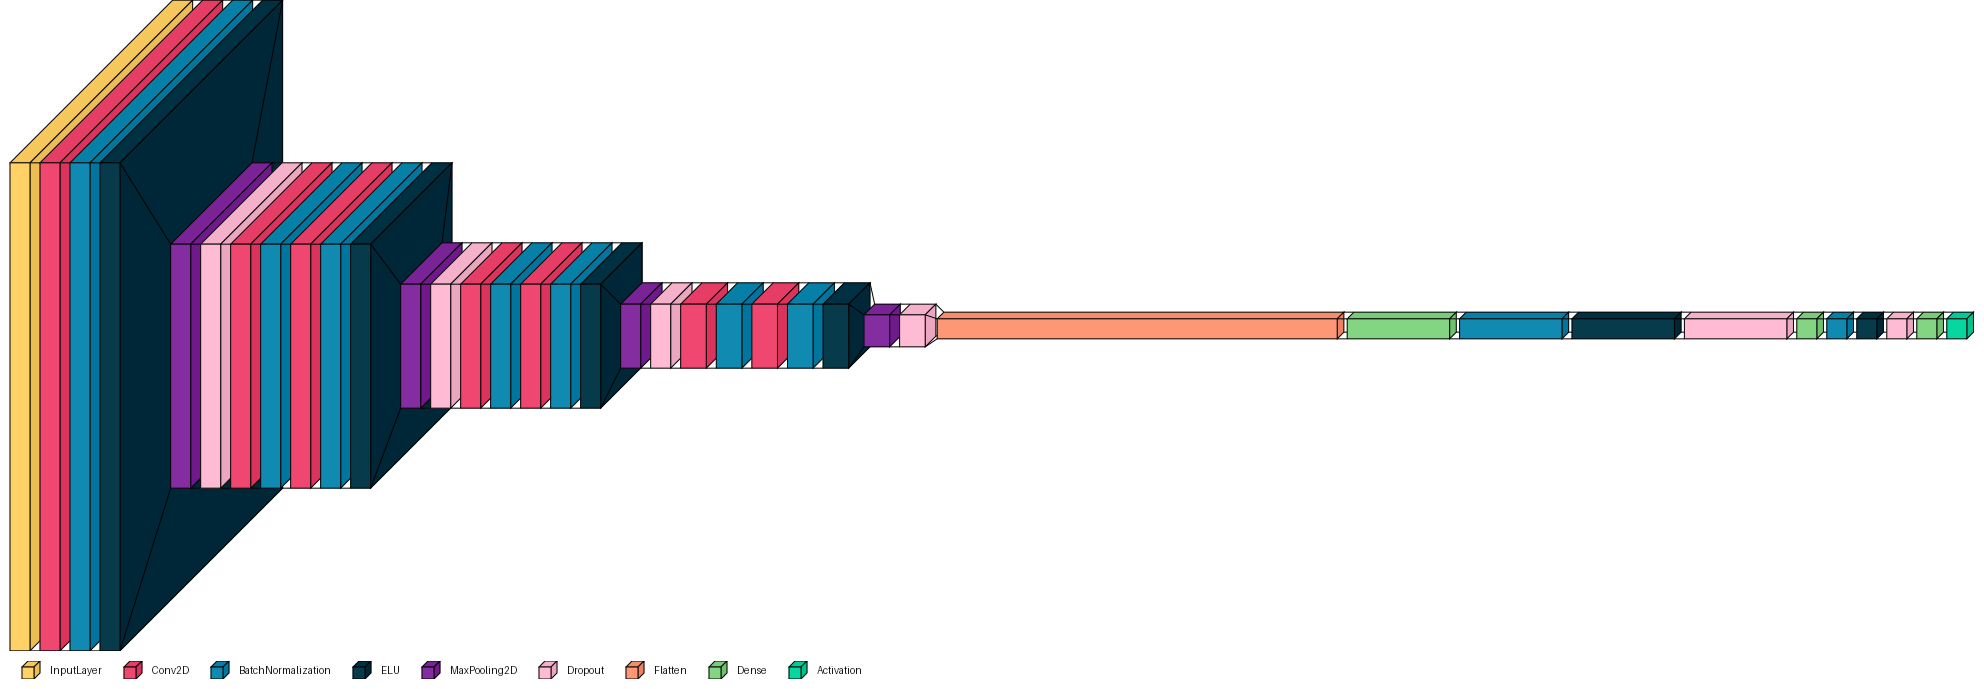

In [14]:
encoded = feature_extraction(input_layer)
output_layer = fully_connected(encoded)

model = Model(inputs=input_layer, outputs=output_layer)
visualkeras.layered_view(model, to_file='visualkeras_cnn.png', legend=True)

### Chargement des images

In [4]:
# ==========================================
# ==========CHARGEMENT DES IMAGES===========
# ==========================================

# training_data_generator: charge les données d'entrainement en mémoire
# quand il charge les images, il les ajuste (change la taille, les dimensions, la direction ...)
# aléatoirement afin de rendre le modèle plus robuste à la position du sujet dans les images
# Note: On peut utiliser cette méthode pour augmenter le nombre d'images d'entrainement (data augmentation)
training_data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,  # Rotation
    width_shift_range=0.2,  # Décalage horizontal
    height_shift_range=0.2,  # Décalage vertical
    shear_range=0.2,  # Déformation diagonale
    zoom_range=0.2,  # Zoom
    horizontal_flip=True,
    validation_split=0.2 # 20% des données d'entrainement pour la validation
    )

# validation_data_generator: charge les données de validation en memoire
#validation_data_generator = ImageDataGenerator(rescale=1. / 255)

# training_generator: indique la méthode de chargement des données d'entrainement
training_generator = training_data_generator.flow_from_directory(
    trainPath, # Place des images d'entrainement
    color_mode=images_color_mode, # couleur des images
    target_size=(image_scale, image_scale),# taille des images
    batch_size=training_batch_size, # nombre d'images à entrainer (batch size)
    class_mode="categorical", # classement binaire (problème de 2 classes)
    shuffle=True, # on "brasse" (shuffle) les données -> pour prévenir le surapprentissage
    subset="training", # on indique que dans l'ensemble d'entrainement cette partie est reservee aux donnees d'entrainement
    seed=seed_value
    )

# validation_generator: indique la méthode de chargement des données de validation
validation_generator = training_data_generator.flow_from_directory(
    trainPath, # Place des images de validation
    color_mode=images_color_mode, # couleur des images
    target_size=(image_scale, image_scale),  # taille des images
    batch_size=validation_batch_size,  # nombre d'images à valider
    class_mode="categorical",  # classement binaire (problème de 2 classes)
    shuffle=True, # on "brasse" (shuffle) les données -> pour prévenir le surapprentissage
    subset="validation", # on indique que dans l'ensemble d'entrainement cette partie est reservee aux donnees de validation
    seed=seed_value
    )
# On imprime l'indice de chaque classe (Keras numerote les classes selon l'ordre des dossiers des classes)
# Dans ce cas => [2: 0 et 7:1]
print(training_generator.class_indices)
print(validation_generator.class_indices)

# On charge les données d'entrainement et de validation
# x_train: Les données d'entrainement
# y_train: Les Ètiquettes des données d'entrainement
# x_val: Les données de validation
# y_val: Les Ètiquettes des données de validation
(x_train, y_train) = next(training_generator)
(x_val, y_val) = next(validation_generator)

Found 19200 images belonging to 6 classes.
Found 4800 images belonging to 6 classes.
{'baleine': 0, 'dauphin': 1, 'morse': 2, 'phoque': 3, 'requin': 4, 'requinbaleine': 5}
{'baleine': 0, 'dauphin': 1, 'morse': 2, 'phoque': 3, 'requin': 4, 'requinbaleine': 5}


### Entrainement du modèle

In [5]:
# ==========================================
# ==============ENTRAINEMENT================
# ==========================================

# Savegarder le modèle avec la meilleure validation accuracy ('val_acc')
# Note: on sauvegarder le modèle seulement quand la précision de la validation s'améliore
modelcheckpoint = ModelCheckpoint(filepath=modelsPath,
                                  monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')

start_time = time.time()  # Démarrer le timer

# entrainement du modèle
classifier = model.fit(x_train, y_train,
                       epochs=fit_epochs, # nombre d'époques
                       batch_size=fit_batch_size, # nombre d'images entrainées ensemble
                       validation_data=(x_val, y_val), # données de validation
                       verbose=1, # mets cette valeur ‡ 0, si vous voulez ne pas afficher les détails d'entrainement
                       callbacks=[modelcheckpoint], # les fonctions à appeler à la fin de chaque époque (dans ce cas modelcheckpoint: qui sauvegarde le modèle)
                       shuffle=True)# shuffle les images

end_time = time.time()  # Arrêter le timer
execution_time = end_time - start_time  # Calcul du temps d'exécution
# Affichage du temps d'exécution en minutes et secondes
print(f"Temps d'exécution : {execution_time // 60:.0f} min {execution_time % 60:.2f} sec")


Epoch 1/250
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.3989 - loss: 3.4268
Epoch 1: val_accuracy improved from -inf to 0.28458, saving model to Model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 54s 102ms/step - accuracy: 0.3990 - loss: 3.4247 - val_accuracy: 0.2846 - val_loss: 2.5124
Epoch 2/250
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.5089 - loss: 1.7207
Epoch 2: val_accuracy improved from 0.28458 to 0.51729, saving model to Model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 29s 96ms/step - accuracy: 0.5089 - loss: 1.7205 - val_accuracy: 0.5173 - val_loss: 1.6768
Epoch 3/250
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.5482 - loss: 1.5711
Epoch 3: val_accuracy did not improve from 0.51729
300/300 ━━━━━━━━━━━━━━━━━━━━ 27s 90ms/step - accuracy: 0.5482 - loss: 1.5710 - val_accuracy: 0.4398 - val_loss: 2.1878
Epoch 4/250
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.5667 - loss: 1.5343
Epoch 4: val_accuracy did not improve from 0.51729
300/300 ━━━━━━━━━━━━━━━

### Affichage des résultats

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


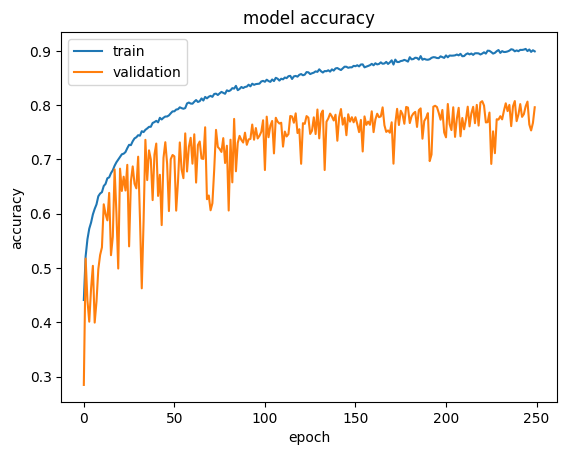

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


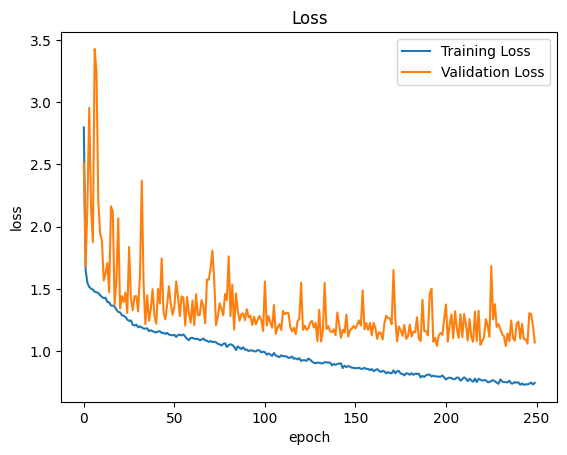

In [6]:
# ==========================================
# ========AFFICHAGE DES RESULTATS===========
# ==========================================

# ***********************************************
#                    QUESTION
# ***********************************************
#
# 4) Afficher le temps d'execution
#
# ***********************************************

# Plot accuracy over epochs (precision par époque)
print(classifier.history.keys())
plt.plot(classifier.history['accuracy'])
plt.plot(classifier.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
fig = plt.gcf()
plt.show()

# ***********************************************
#                    QUESTION
# ***********************************************
#
# 5) Afficher la courbe d’exactitude par époque (Training vs Validation) ainsi que la courbe de perte (loss)
#
# ***********************************************

print(classifier.history.keys())
plt.plot(classifier.history['loss'])
plt.plot(classifier.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training Loss', 'Validation Loss'])
fig = plt.gcf()
plt.show()

### Conclusion

Nous avons développé et entraîné un réseau de neurones convolutif (CNN) pour la classification de six espèces aquatiques, en nous appuyant sur un jeu de 24 000 images réparties équitablement entre l'entraînement et la validation.

L’architecture du modèle repose sur une série de blocs convolutifs, chacun constitué de deux couches Conv2D, suivies de BatchNormalization, d’une activation ELU, d’un MaxPooling et d’un Dropout, afin de renforcer la robustesse du modèle et de limiter le surapprentissage. Cette structure hiérarchique permet une extraction progressive et efficace des caractéristiques visuelles.

Grâce à cette approche, le modèle a atteint une exactitude de 90 % sur le jeu d’entraînement et 81 % sur le jeu de validation, soit une performance proche de notre objectif initial (≥ 82 % sur le jeu de test). Ces résultats encourageants justifient le passage à la phase d’évaluation finale sur les données de test.